<a href="https://colab.research.google.com/github/davideneffat/movie_recommendations/blob/main/movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
import pandas as pd

# Download MovieLens dataset
url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"   #la versione ridotta
zip_file = tf.keras.utils.get_file("ml-latest-small.zip", url, extract=True, cache_dir='./')
extracted_folder = zip_file.replace('.zip', '')

# Load ratings data into a Pandas DataFrame
ratings_file = extracted_folder + '/ratings.csv'
ratings_df = pd.read_csv(ratings_file)

# Display the first 10 rows
print("First 10 rows:")
print(ratings_df.head(10))

# Display the last 10 rows
print("\nLast 10 rows:")
print(ratings_df.tail(10))


978202/978202 [==============================] - 0s 0us/step
First 10 rows:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
5       1       70     3.0  964982400
6       1      101     5.0  964980868
7       1      110     4.0  964982176
8       1      151     5.0  964984041
9       1      157     5.0  964984100

Last 10 rows:
        userId  movieId  rating   timestamp
100826     610   162350     3.5  1493849971
100827     610   163937     3.5  1493848789
100828     610   163981     3.5  1493850155
100829     610   164179     5.0  1493845631
100830     610   166528     4.0  1493879365
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415


In [15]:
dataset = ratings_df
type(dataset)

pandas.core.frame.DataFrame

In [16]:
dataset.shape

(100836, 4)

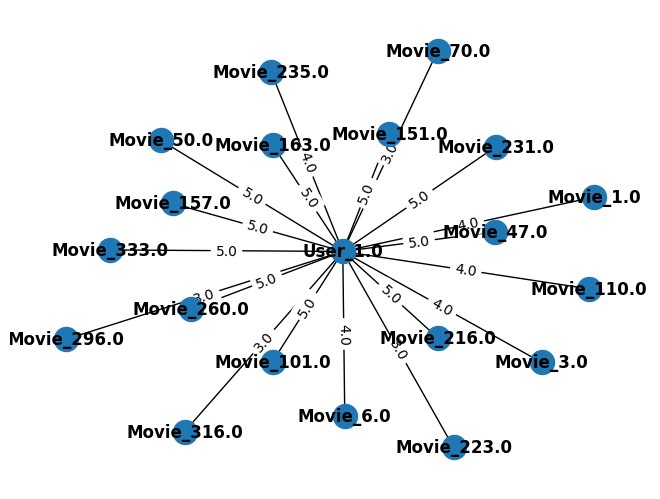

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph using NetworkX
G = nx.Graph()

# Add nodes (users and movies) and edges (interactions)
for _, row in dataset.iterrows():
    user_id = f"User_{row['userId']}"
    movie_id = f"Movie_{row['movieId']}"

    G.add_node(user_id, bipartite=0)
    G.add_node(movie_id, bipartite=1)
    rating = row['rating']
    G.add_edge(user_id, movie_id, weight=rating)

# Get the first 20 nodes
nodes_to_print = list(G.nodes)[:20]

# Create a subgraph with only the first 20 nodes
subgraph = G.subgraph(nodes_to_print)

# Draw the subgraph
pos = nx.spring_layout(subgraph)  # You can choose a different layout if needed
nx.draw(subgraph, pos, with_labels=True, font_weight='bold')
labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)

# Show the plot
plt.show()

In [18]:
print(list(G.nodes)[:20])

['User_1.0', 'Movie_1.0', 'Movie_3.0', 'Movie_6.0', 'Movie_47.0', 'Movie_50.0', 'Movie_70.0', 'Movie_101.0', 'Movie_110.0', 'Movie_151.0', 'Movie_157.0', 'Movie_163.0', 'Movie_216.0', 'Movie_223.0', 'Movie_231.0', 'Movie_235.0', 'Movie_260.0', 'Movie_296.0', 'Movie_316.0', 'Movie_333.0']


In [19]:
neighbors = list(G.neighbors('User_1.0'))
print(len(neighbors))

232


In [20]:
import itertools

# Assuming `G` is your graph created with weighted edges

def find_similar_user(target_user, G):
    user_movies = set(G.neighbors(target_user))

    most_similar_user = None
    highest_similarity = 0

    for node in G.nodes():
        if 'User' in node and node != target_user:
            other_user_movies = set(G.neighbors(node))

            # Calculate Jaccard similarity coefficient
            jaccard_similarity = len(user_movies.intersection(other_user_movies)) / len(user_movies.union(other_user_movies))

            # Calculate Pearson correlation coefficient
            user_ratings = [G[target_user][movie]['weight'] for movie in user_movies]
            other_user_ratings = [G[node][movie]['weight'] for movie in other_user_movies]

            #pearson_correlation = nx.degree_pearson_correlation_coefficient(G.subgraph(user_movies), G.subgraph(other_user_movies))

            # Use a combination of Jaccard and Pearson correlation as the similarity measure
            #similarity = 0.5 * jaccard_similarity + 0.5 * pearson_correlation
            similarity = jaccard_similarity

            if similarity > highest_similarity:
                most_similar_user = node
                highest_similarity = similarity

    return most_similar_user, highest_similarity

# Example: Find a similar user for 'User_1.0'
target_user = 'User_1.0'
similar_user, similarity = find_similar_user(target_user, G)

print(f"The most similar user to {target_user} is {similar_user} with a similarity of {similarity:.2f}")


The most similar user to User_1.0 is User_313.0 with a similarity of 0.23


In [21]:
print(ratings_df[ratings_df['userId'] == 1])

     userId  movieId  rating  timestamp
0         1        1     4.0  964982703
1         1        3     4.0  964981247
2         1        6     4.0  964982224
3         1       47     5.0  964983815
4         1       50     5.0  964982931
..      ...      ...     ...        ...
227       1     3744     4.0  964980694
228       1     3793     5.0  964981855
229       1     3809     4.0  964981220
230       1     4006     4.0  964982903
231       1     5060     5.0  964984002

[232 rows x 4 columns]


In [22]:
print(ratings_df[ratings_df['userId'] == 313])

       userId  movieId  rating   timestamp
48241     313        6     3.0  1030556299
48242     313       10     4.0  1030556439
48243     313       29     4.0  1030474666
48244     313       32     4.0  1030475177
48245     313       39     4.0  1030555731
...       ...      ...     ...         ...
48576     313     5463     4.0  1030475237
48577     313     5538     1.0  1030558213
48578     313     5539     1.0  1030558213
48579     313     5540     5.0  1030475459
48580     313     5544     4.0  1030475254

[340 rows x 4 columns]


In [35]:
!pip install stellargraph

import stellargraph as sg
from stellargraph.layer import GraphSAGE
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.mapper import GraphSAGENodeGenerator
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

# Assuming you have a graph G with nodes and weighted edges

# Convert NetworkX graph to StellarGraph object
G_stellar = sg.StellarGraph(G, node_features=None)

# Define the GraphSAGE model
generator = GraphSAGENodeGenerator(G_stellar, batch_size=50, num_samples=[5, 5])
model = GraphSAGE(layer_sizes=[32, 16], generator=generator, bias=True, dropout=0.5)

# Build the model
x_inp, x_out = model.in_out_tensors()

# Add a binary classification layer
prediction = keras.layers.Dense(units=1, activation="sigmoid")(x_out)

# Use the model for node classification task
node_classification_model = keras.Model(inputs=x_inp, outputs=prediction)
node_classification_model.compile(optimizer=keras.optimizers.Adam(lr=0.005), loss=keras.losses.binary_crossentropy, metrics=["acc"])

# Train the model
labels = G_stellar.nodes["User_1.0"].data["bipartite"]
train_nodes, test_nodes = model_selection.train_test_split(labels.index, train_size=0.1, stratify=labels)
history = node_classification_model.fit(generator.flow(train_nodes), epochs=10, validation_data=generator.flow(test_nodes))

# Evaluate the model
test_metrics = node_classification_model.evaluate(generator.flow(test_nodes))
print(f"Test Accuracy: {test_metrics[1]}")


Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
ModuleNotFoundError: No module named 'pip'


ModuleNotFoundError: ignored

# Nuova sezione

In [34]:
!python --version

Python 3.7.17


In [44]:
!pip install stellargraph

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/main.py", line 9, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/main_parser.py", line 8, in <module>
    from pip._internal.cli import cmdoptions
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/cmdoptions.py", line 23, in <module>
    from pip._internal.cli.parser import ConfigOptionParser
  File "/usr/lib/python3/dist-packages/pip/_internal/cli/parser.py", line 12, in <module>
    from pip._internal.configuration import Configuration, ConfigurationError
  File "/usr/lib/python3/dist-packages/pip/_internal/configuration.py", line 26, in <module>
    f

In [43]:
!apt-get install python3-distutils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-distutils is already the newest version (3.10.8-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
